Device: cuda, Model: smallcnn

Starting Experiments: smallcnn, α=0.5, 30 rounds

=== FedSAM (Baseline) ===
Round   1: Loss=2.1762, Acc=0.2527
Round   2: Loss=2.0350, Acc=0.2817
Round   3: Loss=1.9322, Acc=0.2988
Round   4: Loss=1.8417, Acc=0.3326
Round   5: Loss=1.7688, Acc=0.3541
Round   6: Loss=1.6831, Acc=0.3840
Round   7: Loss=1.6258, Acc=0.3984
Round   8: Loss=1.5783, Acc=0.4181
Round   9: Loss=1.5339, Acc=0.4397
Round  10: Loss=1.4990, Acc=0.4469
Round  11: Loss=1.4704, Acc=0.4598
Round  12: Loss=1.4552, Acc=0.4678
Round  13: Loss=1.4308, Acc=0.4756
Round  14: Loss=1.4229, Acc=0.4726
Round  15: Loss=1.3871, Acc=0.4918
Round  16: Loss=1.3722, Acc=0.4913
Round  17: Loss=1.3554, Acc=0.4987
Round  18: Loss=1.3368, Acc=0.5050
Round  19: Loss=1.3221, Acc=0.5099
Round  20: Loss=1.3076, Acc=0.5140
Round  21: Loss=1.2954, Acc=0.5222
Round  22: Loss=1.2776, Acc=0.5260
Round  23: Loss=1.2669, Acc=0.5285
Round  24: Loss=1.2473, Acc=0.5406
Round  25: Loss=1.2380, Acc=0.5417
Round  26: Loss=1.

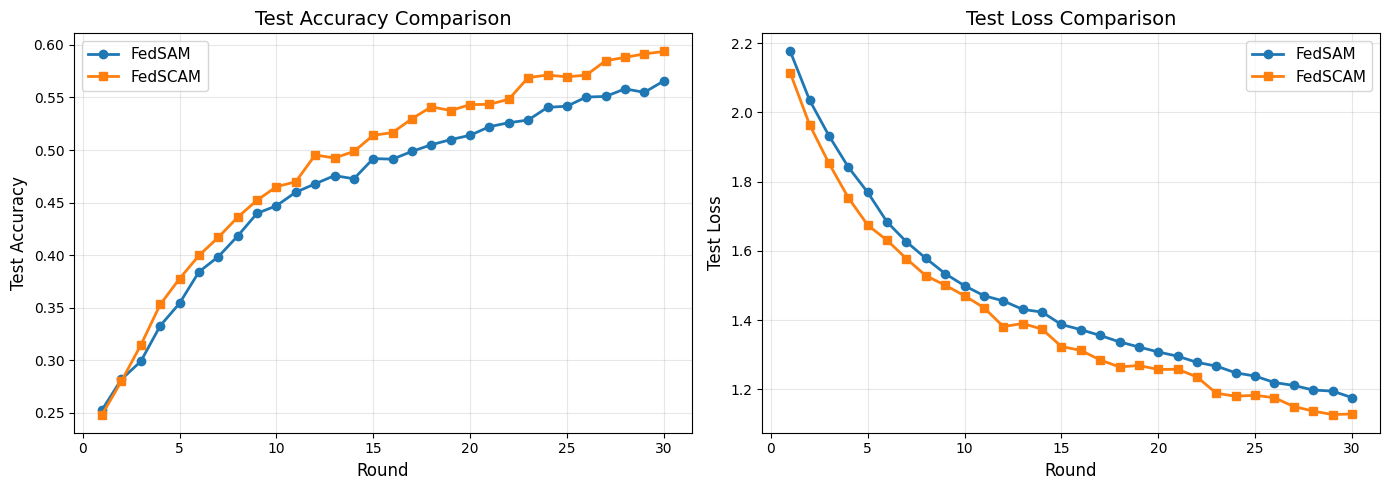


FINAL RESULTS
FedSAM   - Final Acc: 0.5657, Best Acc: 0.5657
FedSCAM  - Final Acc: 0.5938, Best Acc: 0.5938
Improvement: 2.81%


In [ ]:
import copy, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

CONFIG = {
    'num_clients': 10,
    'client_frac': 1.0,
    'rounds': 30,
    'local_epochs': 3,
    'batch_size': 64,
    'lr': 0.01,
    'dirichlet_alpha': 0.5,
    'model_type': 'smallcnn', 
    
    'fedsam_rho': 0.05,
    
    'fedscam_rho_max': 0.05,
    'fedscam_alpha_rho': 1.0,
    'fedscam_kappa_h': 1.0,
    'fedscam_beta_global': 0.8,
    'fedscam_gamma_weight': 1.0,
    'fedscam_n_clusters': 3,
    'fedscam_downweight_conflict': 0.5,
    'fedscam_summary_dim': 512,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}, Model: {CONFIG['model_type']}")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, 
                                  transform=transform_train)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, 
                                transform=transform_test)

def dirichlet_split(dataset, n_clients, alpha=0.5):
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    n_classes = labels.max() + 1
    client_idxs = [[] for _ in range(n_clients)]
    
    for k in range(n_classes):
        idx_k = np.where(labels == k)[0]
        np.random.shuffle(idx_k)
        props = np.random.dirichlet([alpha] * n_clients)
        props = (props * len(idx_k)).astype(int)
        props[-1] = len(idx_k) - props[:-1].sum()
        
        ptr = 0
        for i, p in enumerate(props):
            if p > 0:
                client_idxs[i].extend(idx_k[ptr:ptr+p])
            ptr += p
    
    return [DataLoader(Subset(dataset, idxs if idxs else [0]), 
                      batch_size=CONFIG['batch_size'], shuffle=True)
            for idxs in client_idxs]

client_loaders = dirichlet_split(train_dataset, CONFIG['num_clients'], 
                                 CONFIG['dirichlet_alpha'])
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        from torchvision.models import resnet18
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
    
    def forward(self, x):
        return self.model(x)

def create_model():
    return SmallCNN() if CONFIG['model_type'] == 'smallcnn' else ResNet18()

class SAM:
    def __init__(self, params, base_opt, rho=0.05):
        self.params = list(params)
        self.optimizer = base_opt(self.params, lr=CONFIG['lr'])
        self.rho = rho
    
    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def first_step(self):
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in self.params 
                             if p.grad is not None))
        for p in self.params:
            if p.grad is not None:
                eps = self.rho * p.grad / (norm + 1e-12)
                p.data.add_(eps)
                p._eps = eps
    
    def second_step(self):
        for p in self.params:
            if hasattr(p, '_eps'):
                p.data.sub_(p._eps)
                del p._eps
        self.optimizer.step()

def state_to_vec(state):
    return np.concatenate([v.cpu().numpy().ravel() for v in state.values()])

def vec_to_state(vec, template):
    new = {}; ptr = 0
    for k, v in template.items():
        n = v.numel()
        new[k] = torch.from_numpy(vec[ptr:ptr+n].reshape(v.shape)).type(v.dtype)
        ptr += n
    return new

def compute_delta(before, after):
    return state_to_vec(after) - state_to_vec(before)

def normalize(vec):
    n = np.linalg.norm(vec)
    return vec / (n + 1e-12) if n > 1e-12 else vec

_proj_cache = {}
def random_project(vec, dim):
    key = len(vec)
    if key not in _proj_cache:
        _proj_cache[key] = np.random.randn(dim, key) / np.sqrt(dim)
    return _proj_cache[key] @ vec

def evaluate(model, loader):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss += F.cross_entropy(out, y, reduction='sum').item()
            correct += out.argmax(1).eq(y).sum().item()
            total += y.size(0)
    return loss/total, correct/total

def fedsam_client(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = copy.deepcopy(model.state_dict())
    
    sam = SAM(model.parameters(), optim.SGD, rho=rho)
    model.train()
    n_samples = 0
    
    for _ in range(CONFIG['local_epochs']):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)
            
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.first_step()
            
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.second_step()
    
    return compute_delta(before, model.state_dict()), n_samples

def fedsam_aggregate(global_state, deltas, sizes):
    weights = np.array(sizes) / sum(sizes)
    agg = sum(d * w for d, w in zip(deltas, weights))
    new_vec = state_to_vec(global_state) + agg
    return vec_to_state(new_vec, global_state)

def run_fedsam():
    print("\n=== FedSAM (Baseline) ===")
    model = create_model().to(device)
    global_state = model.state_dict()
    accs, losses = [], []
    
    for r in range(1, CONFIG['rounds']+1):
        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)
        
        deltas, sizes = [], []
        for cid in selected:
            d, n = fedsam_client(global_state, client_loaders[cid], 
                                CONFIG['fedsam_rho'])
            deltas.append(d)
            sizes.append(n)
        
        global_state = fedsam_aggregate(global_state, deltas, sizes)
        
        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss); accs.append(acc)
        
        print(f"Round {r:3d}: Loss={loss:.4f}, Acc={acc:.4f}")
    
    return {'accs': accs, 'losses': losses}

def compute_heterogeneity(model, loader, n_batches=3):
    model.train()
    norms = []
    for i, (x, y) in enumerate(loader):
        if i >= n_batches: break
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        F.cross_entropy(model(x), y).backward()
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters() 
                             if p.grad is not None)).item()
        norms.append(norm)
    return np.mean(norms) if norms else 0.0

def fedscam_pilot(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = copy.deepcopy(model.state_dict())
    sam = SAM(model.parameters(), optim.SGD, rho=rho)
    
    try:
        x, y = next(iter(loader))
    except:
        return np.zeros(CONFIG['fedscam_summary_dim'])
    
    x, y = x.to(device), y.to(device)
    sam.zero_grad()
    F.cross_entropy(model(x), y).backward()
    sam.first_step()
    sam.zero_grad()
    F.cross_entropy(model(x), y).backward()
    sam.second_step()
    
    delta = compute_delta(before, model.state_dict())
    return random_project(normalize(delta), CONFIG['fedscam_summary_dim'])

def fedscam_client(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = copy.deepcopy(model.state_dict())
    sam = SAM(model.parameters(), optim.SGD, rho=rho)
    model.train()
    n_samples = 0
    
    for _ in range(CONFIG['local_epochs']):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.first_step()
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.second_step()
    
    delta = compute_delta(before, model.state_dict())
    summary = random_project(normalize(delta), CONFIG['fedscam_summary_dim'])
    return delta, summary, n_samples

def harmonize(deltas, summaries, down, k):
    if len(deltas) <= 1: return deltas
    
    labels = KMeans(k, random_state=SEED, n_init=10).fit_predict(
        np.stack(summaries))
    
    harm = [d.copy() for d in deltas]
    for g in range(k):
        idxs = [i for i, l in enumerate(labels) if l == g]
        if len(idxs) <= 1: continue
        
        for i in idxs:
            for j in idxs:
                if i >= j: continue
                cos = np.dot(harm[i], harm[j]) / (
                    np.linalg.norm(harm[i]) * np.linalg.norm(harm[j]) + 1e-12)
                if cos < 0:
                    if np.linalg.norm(harm[i]) < np.linalg.norm(harm[j]):
                        harm[i] *= down
                    else:
                        harm[j] *= down
    return harm

def fedscam_aggregate(global_state, deltas, h_list, cos_list, sizes):
    base_w = np.array([1/(1 + CONFIG['fedscam_gamma_weight']*h) for h in h_list])
    align_w = np.array([max(0, 1 + CONFIG['fedscam_beta_global']*c) 
                       for c in cos_list])
    weights = base_w * align_w
    weights = weights / (weights.sum() + 1e-12)
    
    agg = sum(d*w for d, w in zip(deltas, weights))
    new_vec = state_to_vec(global_state) + agg
    return vec_to_state(new_vec, global_state)

def run_fedscam():
    print("\n=== FedSCAM (Proposed) ===")
    model = create_model().to(device)
    global_state = model.state_dict()
    accs, losses = [], []
    prev_global = None
    
    for r in range(1, CONFIG['rounds']+1):
        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)
        
        deltas, summaries, h_adjs, coss, sizes = [], [], [], [], []
        
        for cid in selected:
            temp = create_model().to(device)
            temp.load_state_dict(global_state)
            h = compute_heterogeneity(temp, client_loaders[cid], n_batches=3)
            
            rho_p = 0.5 * CONFIG['fedscam_rho_max'] / (
                1 + CONFIG['fedscam_alpha_rho'] * h)
            pilot = fedscam_pilot(global_state, client_loaders[cid], rho_p)
            
            if prev_global is not None:
                cos = np.clip(np.dot(normalize(pilot), prev_global) / (
                    np.linalg.norm(normalize(pilot)) * 
                    np.linalg.norm(prev_global) + 1e-12), -1, 1)
            else:
                cos = 0.0
            
            h_adj = h * max(0, 1 - CONFIG['fedscam_kappa_h'] * cos)
            rho = CONFIG['fedscam_rho_max'] / (
                1 + CONFIG['fedscam_alpha_rho'] * h_adj)
            
            d, s, n = fedscam_client(global_state, client_loaders[cid], rho)
            deltas.append(d); summaries.append(s)
            h_adjs.append(h_adj); coss.append(cos); sizes.append(n)
        
        harm = harmonize(deltas, summaries, 
                        CONFIG['fedscam_downweight_conflict'],
                        min(CONFIG['fedscam_n_clusters'], len(deltas)))
        
        global_state = fedscam_aggregate(global_state, harm, h_adjs, 
                                         coss, sizes)
        prev_global = normalize(random_project(state_to_vec(global_state), 
                                              CONFIG['fedscam_summary_dim']))
        
        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss); accs.append(acc)
        
        
        print(f"Round {r:3d}: Loss={loss:.4f}, Acc={acc:.4f}")
    
    return {'accs': accs, 'losses': losses}

print(f"\nStarting Experiments: {CONFIG['model_type']}, "
      f"α={CONFIG['dirichlet_alpha']}, {CONFIG['rounds']} rounds")

fedsam_res = run_fedsam()
fedscam_res = run_fedscam()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
rounds = range(1, CONFIG['rounds']+1)

ax1.plot(rounds, fedsam_res['accs'], 'o-', label='FedSAM', linewidth=2)
ax1.plot(rounds, fedscam_res['accs'], 's-', label='FedSCAM', linewidth=2)
ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy Comparison', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(rounds, fedsam_res['losses'], 'o-', label='FedSAM', linewidth=2)
ax2.plot(rounds, fedscam_res['losses'], 's-', label='FedSCAM', linewidth=2)
ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Test Loss', fontsize=12)
ax2.set_title('Test Loss Comparison', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fedsam_vs_fedscam.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"FedSAM   - Final Acc: {fedsam_res['accs'][-1]:.4f}, "
      f"Best Acc: {max(fedsam_res['accs']):.4f}")
print(f"FedSCAM  - Final Acc: {fedscam_res['accs'][-1]:.4f}, "
      f"Best Acc: {max(fedscam_res['accs']):.4f}")
print(f"Improvement: {(fedscam_res['accs'][-1] - fedsam_res['accs'][-1])*100:.2f}%")

Device: cuda, Model: resnet18
Loading data...

Config: resnet18, α=0.5, 50 rounds


=== FedSCAM ===

Initializing projection: 11173962 -> 256
Projection ready: samples 10000 dims, matrix size: 10.2MB
Round  1: Loss=2.1433 Acc=0.2177 
Round  2: Loss=1.9905 Acc=0.2419 
Round  3: Loss=1.9182 Acc=0.2536 
Round  4: Loss=1.8473 Acc=0.2881 
Round  5: Loss=1.7877 Acc=0.3064 
Round  6: Loss=1.7351 Acc=0.3405 
Round  7: Loss=1.6987 Acc=0.3459 
Round  8: Loss=1.6433 Acc=0.3684 
Round  9: Loss=1.6093 Acc=0.3840 
Round 10: Loss=1.5849 Acc=0.3929 
Round 11: Loss=1.5482 Acc=0.4118 
Round 12: Loss=1.5292 Acc=0.4146 
Round 13: Loss=1.4889 Acc=0.4386 
Round 14: Loss=1.4673 Acc=0.4426 
Round 15: Loss=1.4563 Acc=0.4494 
Round 16: Loss=1.4297 Acc=0.4663 
Round 17: Loss=1.4130 Acc=0.4674 
Round 18: Loss=1.3834 Acc=0.4730 
Round 19: Loss=1.3792 Acc=0.4762 
Round 20: Loss=1.3686 Acc=0.4825 
Round 21: Loss=1.3528 Acc=0.4903 
Round 22: Loss=1.3243 Acc=0.5040 
Round 23: Loss=1.3280 Acc=0.4996 
Round 24: Loss=1.3

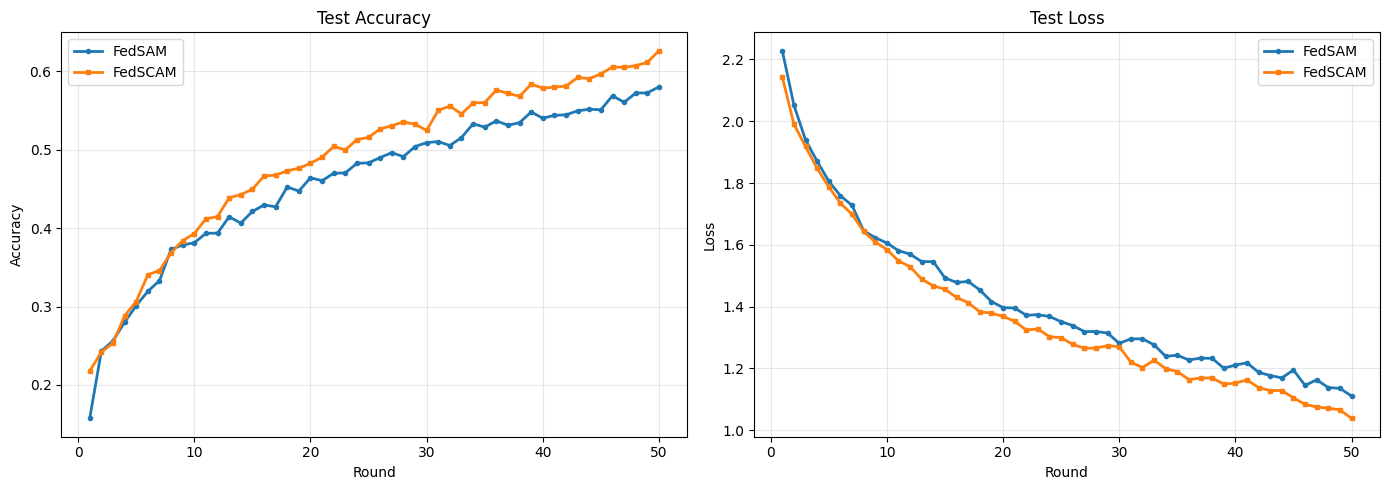


RESULTS
FedSAM:  Final=0.5800 Best=0.5800
FedSCAM: Final=0.6260 Best=0.6260
Gain: +4.60%


In [ ]:
import copy, math, random, gc, hashlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

CONFIG = {
    'num_clients': 10,
    'client_frac': 1.0,
    'rounds': 50,
    'local_epochs': 1,
    'batch_size': 64,
    'lr': 0.01,
    'dirichlet_alpha': 0.5,
    'model_type': 'resnet18',
    
    'fedsam_rho': 0.05,
    
    'fedscam_rho_max': 0.05,
    'fedscam_alpha_rho': 1.0,
    'fedscam_kappa_h': 1.0,
    'fedscam_beta_global': 0.8,
    'fedscam_gamma_weight': 1.0,
    'fedscam_n_clusters': 3,
    'fedscam_downweight_conflict': 0.5,
    'fedscam_summary_dim': 256,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mem_info():
    if torch.cuda.is_available():
        return f"{torch.cuda.memory_allocated()/1e9:.2f}GB"
    return "CPU"

print(f"Device: {device}, Model: {CONFIG['model_type']}")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, 
                                  transform=transform_train)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, 
                                transform=transform_test)

def dirichlet_split(dataset, n_clients, alpha=0.5):
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    n_classes = labels.max() + 1
    client_idxs = [[] for _ in range(n_clients)]
    
    for k in range(n_classes):
        idx_k = np.where(labels == k)[0]
        np.random.shuffle(idx_k)
        props = np.random.dirichlet([alpha] * n_clients)
        props = (props * len(idx_k)).astype(int)
        props[-1] = len(idx_k) - props[:-1].sum()
        
        ptr = 0
        for i, p in enumerate(props):
            if p > 0:
                client_idxs[i].extend(idx_k[ptr:ptr+p])
            ptr += p
    
    return [DataLoader(Subset(dataset, idxs if idxs else [0]), 
                      batch_size=CONFIG['batch_size'], shuffle=True, 
                      num_workers=0, pin_memory=False)
            for idxs in client_idxs]

print("Loading data...")
client_loaders = dirichlet_split(train_dataset, CONFIG['num_clients'], 
                                 CONFIG['dirichlet_alpha'])
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,
                         num_workers=0, pin_memory=False)

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc2(F.relu(self.fc1(x)))

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        from torchvision.models import resnet18
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
    
    def forward(self, x):
        return self.model(x)

def create_model():
    return SmallCNN() if CONFIG['model_type'] == 'smallcnn' else ResNet18()

_projection_matrix = None
_projection_initialized = False

def init_projection():
    global _projection_matrix, _projection_initialized
    
    if _projection_initialized:
        return
    
    dummy = create_model()
    vec_size = sum(p.numel() for p in dummy.parameters())
    
    print(f"\nInitializing projection: {vec_size} -> {CONFIG['fedscam_summary_dim']}")

    n_samples = min(10000, vec_size)
    _projection_matrix = {
        'indices': np.random.choice(vec_size, n_samples, replace=False),
        'weights': np.random.randn(CONFIG['fedscam_summary_dim'], n_samples).astype(np.float32) / np.sqrt(n_samples)
    }
    
    _projection_initialized = True
    print(f"Projection ready: samples {n_samples} dims, matrix size: {_projection_matrix['weights'].nbytes/1e6:.1f}MB")
    del dummy

def fast_project(vec):
    if not _projection_initialized:
        init_projection()
    
    sampled = vec[_projection_matrix['indices']]
    return _projection_matrix['weights'] @ sampled

class SAM:
    def __init__(self, params, rho=0.05):
        self.params = list(params)
        self.optimizer = optim.SGD(self.params, lr=CONFIG['lr'])
        self.rho = rho
    
    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def first_step(self):
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in self.params 
                             if p.grad is not None))
        for p in self.params:
            if p.grad is not None:
                eps = self.rho * p.grad / (norm + 1e-12)
                p.data.add_(eps)
                p._eps = eps
    
    def second_step(self):
        for p in self.params:
            if hasattr(p, '_eps'):
                p.data.sub_(p._eps)
                del p._eps
        self.optimizer.step()

def state_to_vec(state_dict):
    """Convert state dict to vector - ALWAYS same size"""
    return np.concatenate([v.detach().cpu().numpy().astype(np.float32).ravel() 
                          for v in state_dict.values()])

def vec_to_state(vec, template):
    new = {}; ptr = 0
    for k, v in template.items():
        n = v.numel()
        new[k] = torch.from_numpy(vec[ptr:ptr+n].reshape(v.shape)).type(v.dtype)
        ptr += n
    return new

def normalize(vec):
    n = np.linalg.norm(vec)
    return vec / (n + 1e-12) if n > 1e-12 else vec

def clear_mem():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def evaluate(model, loader):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss += F.cross_entropy(out, y, reduction='sum').item()
            correct += out.argmax(1).eq(y).sum().item()
            total += y.size(0)
    return loss/total, correct/total

def fedsam_client(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    
    before_vec = state_to_vec(model.state_dict())
    
    sam = SAM(model.parameters(), rho=rho)
    model.train()
    n_samples = 0
    
    for _ in range(CONFIG['local_epochs']):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)
            
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.first_step()
            
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.second_step()
    
    after_vec = state_to_vec(model.state_dict())
    delta = after_vec - before_vec
    
    del model, sam, before_vec, after_vec
    clear_mem()
    return delta, n_samples

def aggregate(global_state, deltas, sizes):
    weights = np.array(sizes, dtype=np.float32) / sum(sizes)
    agg = np.zeros_like(deltas[0], dtype=np.float32)
    for d, w in zip(deltas, weights):
        agg += d * w
    
    global_vec = state_to_vec(global_state)
    new_vec = global_vec + agg
    result = vec_to_state(new_vec, global_state)
    
    del agg, global_vec, new_vec
    return result

def run_fedsam():
    print("\n=== FedSAM ===")
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())
    accs, losses = [], []
    
    for r in range(1, CONFIG['rounds']+1):
        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)
        
        deltas, sizes = [], []
        for cid in selected:
            d, n = fedsam_client(global_state, client_loaders[cid], CONFIG['fedsam_rho'])
            deltas.append(d)
            sizes.append(n)
        
        global_state = aggregate(global_state, deltas, sizes)
        del deltas
        clear_mem()
        
        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss); accs.append(acc)
        
        
        print(f"Round{r:3d}: Loss={loss:.4f} Acc={acc:.4f}")
    
    return {'accs': accs, 'losses': losses}

def compute_het_simple(global_state, loader):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    model.train()
    
    try:
        x, y = next(iter(loader))
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        F.cross_entropy(model(x), y).backward()
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters() 
                             if p.grad is not None)).item()
    except:
        norm = 1.0
    
    del model
    clear_mem()
    return norm

def get_gradient_direction(global_state, loader):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    
    try:
        x, y = next(iter(loader))
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        F.cross_entropy(model(x), y).backward()
        
        grad_vec = np.concatenate([
            p.grad.detach().cpu().numpy().astype(np.float32).ravel() 
            for p in model.parameters() if p.grad is not None
        ])
        
        summary = fast_project(normalize(grad_vec))
        
        del model, grad_vec
        clear_mem()
        return summary
        
    except Exception as e:
        print(f"Gradient error: {e}")
        del model
        clear_mem()
        return np.zeros(CONFIG['fedscam_summary_dim'], dtype=np.float32)

def fedscam_client(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    
    before_vec = state_to_vec(model.state_dict())
    
    sam = SAM(model.parameters(), rho=rho)
    model.train()
    n_samples = 0
    
    for _ in range(CONFIG['local_epochs']):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.first_step()
            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.second_step()
    
    after_vec = state_to_vec(model.state_dict())
    delta = after_vec - before_vec
    
    summary = fast_project(normalize(delta))
    
    del model, sam, before_vec, after_vec
    clear_mem()
    return delta, summary, n_samples

def harmonize(deltas, summaries, down, k):
    if len(deltas) <= 1:
        return deltas
    
    try:
        labels = KMeans(k, random_state=SEED, n_init=5).fit_predict(np.stack(summaries))
    except:
        return deltas
    
    harm = [d.copy() for d in deltas]
    for g in range(k):
        idxs = [i for i, l in enumerate(labels) if l == g]
        if len(idxs) <= 1:
            continue
        
        for i in idxs:
            for j in idxs:
                if i >= j:
                    continue
                cos = np.dot(harm[i], harm[j]) / (
                    np.linalg.norm(harm[i]) * np.linalg.norm(harm[j]) + 1e-12)
                if cos < 0:
                    if np.linalg.norm(harm[i]) < np.linalg.norm(harm[j]):
                        harm[i] = harm[i] * down
                    else:
                        harm[j] = harm[j] * down
    return harm

def fedscam_aggregate(global_state, deltas, h_list, cos_list, sizes):
    base_w = np.array([1/(1 + CONFIG['fedscam_gamma_weight']*h) for h in h_list], 
                     dtype=np.float32)
    align_w = np.array([max(0, 1 + CONFIG['fedscam_beta_global']*c) for c in cos_list],
                      dtype=np.float32)
    weights = base_w * align_w
    weights = weights / (weights.sum() + 1e-12)
    
    agg = np.zeros_like(deltas[0], dtype=np.float32)
    for d, w in zip(deltas, weights):
        agg += d * w
    
    global_vec = state_to_vec(global_state)
    new_vec = global_vec + agg
    result = vec_to_state(new_vec, global_state)
    
    del agg, global_vec, new_vec
    return result

def run_fedscam():
    print("\n=== FedSCAM ===")
    
    init_projection()
    
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())
    accs, losses = [], []
    prev_global = None
    
    for r in range(1, CONFIG['rounds']+1):
        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)
        
        deltas, summaries, h_adjs, coss, sizes = [], [], [], [], []
        
        for cid in selected:
            h = compute_het_simple(global_state, client_loaders[cid])
            pilot = get_gradient_direction(global_state, client_loaders[cid])
            
            if prev_global is not None:
                cos = np.clip(np.dot(pilot, prev_global) / (
                    np.linalg.norm(pilot) * np.linalg.norm(prev_global) + 1e-12), -1, 1)
            else:
                cos = 0.0
            
            h_adj = h * max(0, 1 - CONFIG['fedscam_kappa_h'] * cos)
            rho = CONFIG['fedscam_rho_max'] / (1 + CONFIG['fedscam_alpha_rho'] * h_adj)
            
            d, s, n = fedscam_client(global_state, client_loaders[cid], rho)
            deltas.append(d); summaries.append(s)
            h_adjs.append(h_adj); coss.append(cos); sizes.append(n)
        
        harm = harmonize(deltas, summaries, CONFIG['fedscam_downweight_conflict'],
                        min(CONFIG['fedscam_n_clusters'], len(deltas)))
        global_state = fedscam_aggregate(global_state, harm, h_adjs, coss, sizes)
        
        global_vec = state_to_vec(global_state)
        prev_global = normalize(fast_project(global_vec))
        
        del deltas, harm, global_vec
        clear_mem()
        
        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss); accs.append(acc)
        
        
        print(f"Round{r:3d}: Loss={loss:.4f} Acc={acc:.4f} ")
    
    return {'accs': accs, 'losses': losses}

print(f"\nConfig: {CONFIG['model_type']}, α={CONFIG['dirichlet_alpha']}, "
      f"{CONFIG['rounds']} rounds\n")


fedscam_res = run_fedscam()
fedsam_res = run_fedsam()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
rounds = range(1, CONFIG['rounds']+1)

ax1.plot(rounds, fedsam_res['accs'], 'o-', label='FedSAM', linewidth=2, markersize=3)
ax1.plot(rounds, fedscam_res['accs'], 's-', label='FedSCAM', linewidth=2, markersize=3)
ax1.set_xlabel('Round'); ax1.set_ylabel('Accuracy')
ax1.set_title('Test Accuracy')
ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(rounds, fedsam_res['losses'], 'o-', label='FedSAM', linewidth=2, markersize=3)
ax2.plot(rounds, fedscam_res['losses'], 's-', label='FedSCAM', linewidth=2, markersize=3)
ax2.set_xlabel('Round'); ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')
ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"FedSAM:  Final={fedsam_res['accs'][-1]:.4f} Best={max(fedsam_res['accs']):.4f}")
print(f"FedSCAM: Final={fedscam_res['accs'][-1]:.4f} Best={max(fedscam_res['accs']):.4f}")
print(f"Gain: {(fedscam_res['accs'][-1]-fedsam_res['accs'][-1])*100:+.2f}%")